<IPython.core.display.Javascript object>


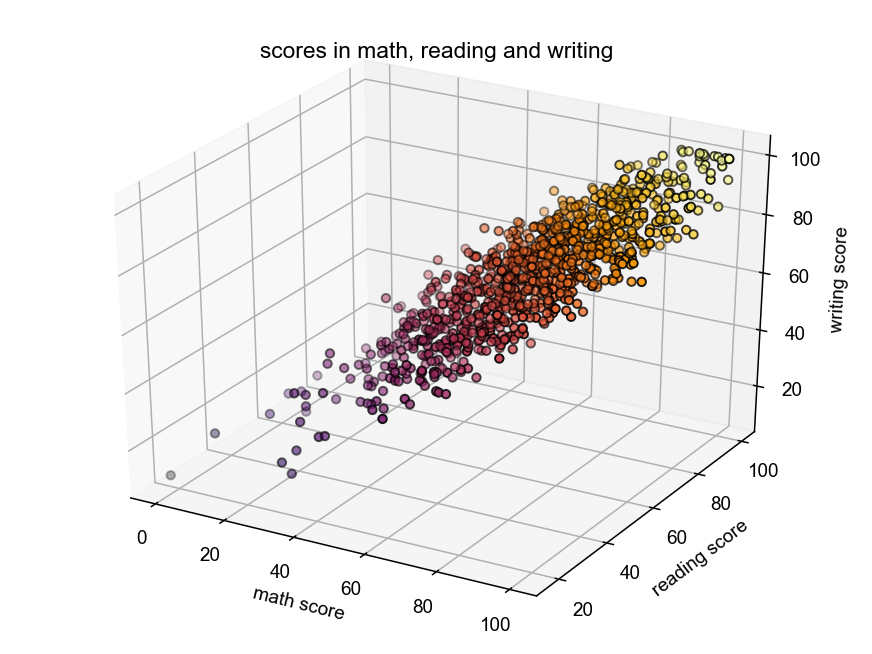

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
# data from: https://www.kaggle.com/spscientist/students-performance-in-exams
df = pd.read_csv('data/StudentsPerformance.csv')

# plot the original data:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs = df['math score']
ys = df['reading score']
zs = df['writing score']
color_control = (df['math score'] + df['reading score'] + df['writing score']) / 300
ax.scatter(xs, ys, zs, marker='o', c=color_control, cmap='inferno', edgecolors='black')
ax.set_xlabel('math score')
ax.set_ylabel('reading score')
ax.set_zlabel('writing score')
ax.set_title('scores in math, reading and writing')
plt.tight_layout()
plt.show()

# goal: reduce the 3 'score' columns to 2 principal components

Fundamental idea of dimensionality reduction via PCA:

Given a matrix X containing N many observations in its rows and M many numerical features in its columns, the eigenvalues of the corresponding (unified) eigenvectors determine, how much the data is spread along the corresponding eigenvector-axis. We can use these so called 'principal axes' to obtain M_pca < M many principal axes with the M_pca biggest eigenvalues instead of the original features.

Firstly, we have to standardize the columns by subtracting the mean (to obtain zero means) and, if necessary, dividing by the standard deviation, in order to bring the columns on the same scale with var(col) = 1 for all columns. This works, because the std has the same unit as the values within the column. Thus, dividing by the std provides plane numbers.

Afterwards we have to calculate the covariance matrix using covmat(X) = c * X.T @ X.
Where c is any constant factor.

We can obtain the (already sorted in descending order) eigenvalues and their corresponding eigenvectors of the covariance matrix of X via eigendecomposition.

Lastly, we can easily choose which principal components we want to keep.


Downside of PCA: PCA merges the original features to fewer principal components and thus is less interpretable.

<IPython.core.display.Javascript object>


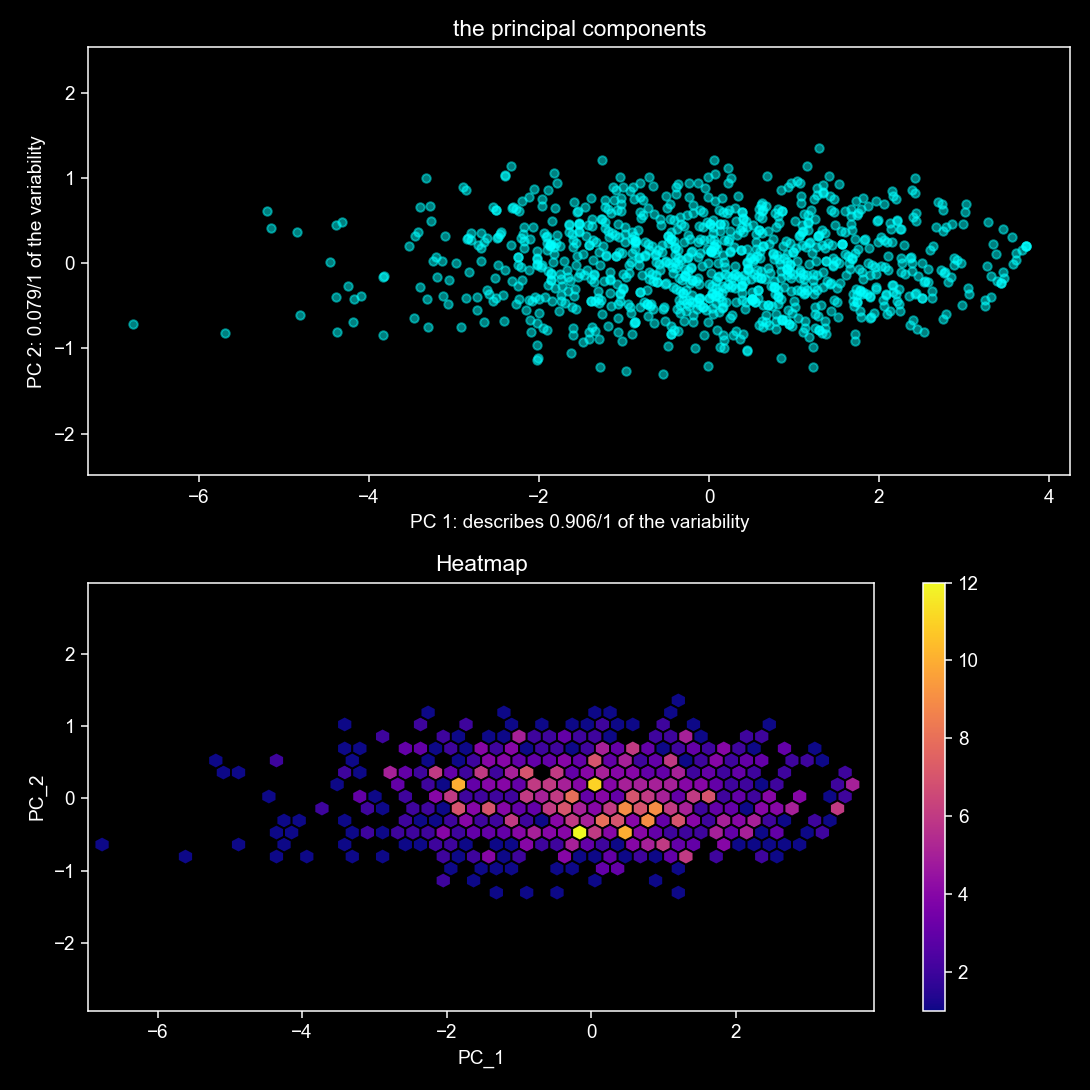

In [2]:
df_pca = df.loc[:, ['math score', 'reading score', 'writing score']]
num_pc = 2

# step 1: standardize the data and obtain X:
# per columns: subtract mean along the column
df_pca = df_pca.apply(lambda col: col - col.mean(), axis=0)
# per column: divide by standard deviation along the column 
# (for practice; even though we already have scores between 0 and 100)
df_pca = df_pca.apply(lambda col: col / col.std(), axis=0)
X = df_pca.values
# step 2: obtain the covariance matrix of X (up to a constant factor) via X.T@X
covmat = X.T @ X
# step 3_ obtain the eigenvalues via eigendecomposition of the covariance matrix
e_val, e_vec = np.linalg.eig(covmat)

# obtain the reduced data by X @ e_vec*, where e_vec*:= the matrix of eigenvectors containing only the
# eigenvectors corresponding to the N largest eigenvalues:
pc = X @ e_vec[:, :num_pc]



# amount of variability which is covered by each pc:
var_pc = np.round(e_val / np.sum(e_val), 3)



# plot the resulting principal components:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize=(8,8))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    df_plot = pd.DataFrame(pc, columns=['PC_1', 'PC_2'])
    df_plot.plot(kind='scatter', x='PC_1', y='PC_2', alpha=0.5, c='cyan', ax=ax1)
    df_plot.plot.hexbin(x='PC_1', y='PC_2', gridsize=(50, 8), cmap="plasma", 
                        edgecolors='black', mincnt=1, ax=ax2)

    ax1.set_xlabel(f'PC 1: describes {var_pc[0]}/1 of the variability')
    ax1.set_ylabel(f'PC 2: {var_pc[1]}/1 of the variability')
    ax1.set_title('the principal components')
    ax1.axis('equal')

    ax2.axis('equal')
    ax2.set_title('Heatmap')

    fig.tight_layout()

Usually, one would decide how many principal components one wants to keep by the values displayed in the Scree plot, i.e. a plot displaying the amount of variability explained by each principal axis.

TODO:SCREE PLOT

<IPython.core.display.Javascript object>


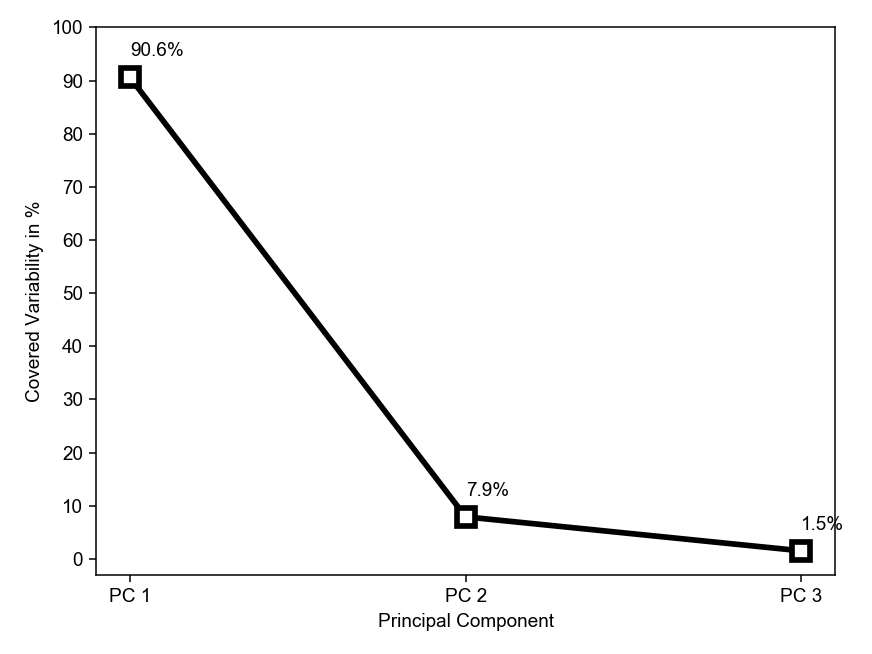

In [3]:

fig_scree = plt.figure()
ax_scree = plt.axes()
pc_num = np.arange(1, len(var_pc)+1)
x_ticks = np.char.add(['PC ']*3, pc_num.astype('str'))
ax_scree.plot(x_ticks, var_pc*100, 
              '-s', color='black',
              markersize=10, linewidth=3,
              markerfacecolor='white',
              markeredgecolor='black',
              markeredgewidth=3)
ax_scree.set_xlabel('Principal Component')
ax_scree.set_ylabel('Covered Variability in %')
ax_scree.set_yticks(np.arange(0, 110, 10))

ax_scree.text('PC 1', var_pc[0]*100 + 4, f'{round(var_pc[0]*100, 1)}%')
ax_scree.text('PC 2', var_pc[1]*100 + 4, f'{round(var_pc[1]*100, 1)}%')
ax_scree.text('PC 3', var_pc[2]*100 + 4, f'{round(var_pc[2]*100, 1)}%')

plt.tight_layout()

It turns out that it definitely makes sense to apply PCA to reduce the dimensions, since even reducing it to just one dimension covers more than 90% of the overall variability of the data. It would even make sense to discard all dimensions but one.

### what else does this result tell us?

<IPython.core.display.Javascript object>


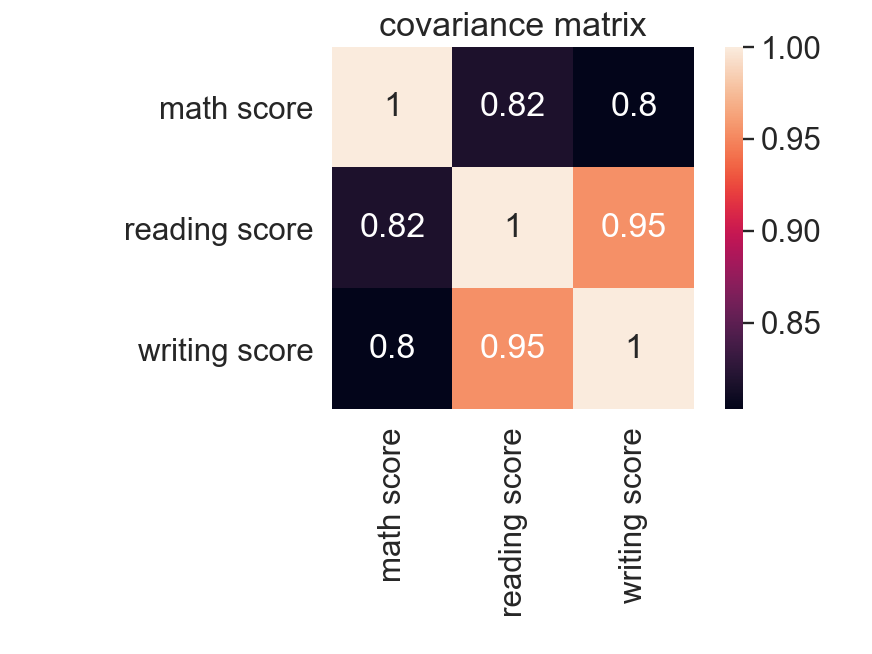

In [4]:
# NOTE: since we standardized each column, each variance equals 1 and thus covmat[0][0] is the scaling factor. 
# of the apprix covariance matrix
covmat_real = covmat/covmat[0][0]
numerical_cols = df.columns[-3:] 

plt.figure()
sns.set(font_scale=1.5)
heatmap = sns.heatmap(covmat_real,
                      square=True,
                      cbar=True,
                      annot=True,
                      xticklabels=numerical_cols,
                      yticklabels=numerical_cols)
                      
plt.tight_layout()
plt.title('covariance matrix')
plt.show()

Since the covariances of all 3 features are positive, we can determine, that high values of one feature correlate with high values of the other features and vice versa. Note that the (pearson) correlation coefficients can be calculated by dividing the covariance of two variables by the product of their standard deviations. Since we already standardized the columns, these covariances equal the correlation coefficients.

One can already see this relationship in Figure 1. This property allows us to reduce to two dimensions (or even one dimension) without losing too much information. 

According to this dataset, students are very  likely to obtain similar scores in all 3 disciplines.